<a href="https://colab.research.google.com/github/SAMashiyane/Residual_CNN_Explanation/blob/main/MobileNetV2_myCustomer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **This is the last part of this notebook that we are going to make my MobileNetV2_customer**

**Inverted Residuals and Linear Bottlenecks**


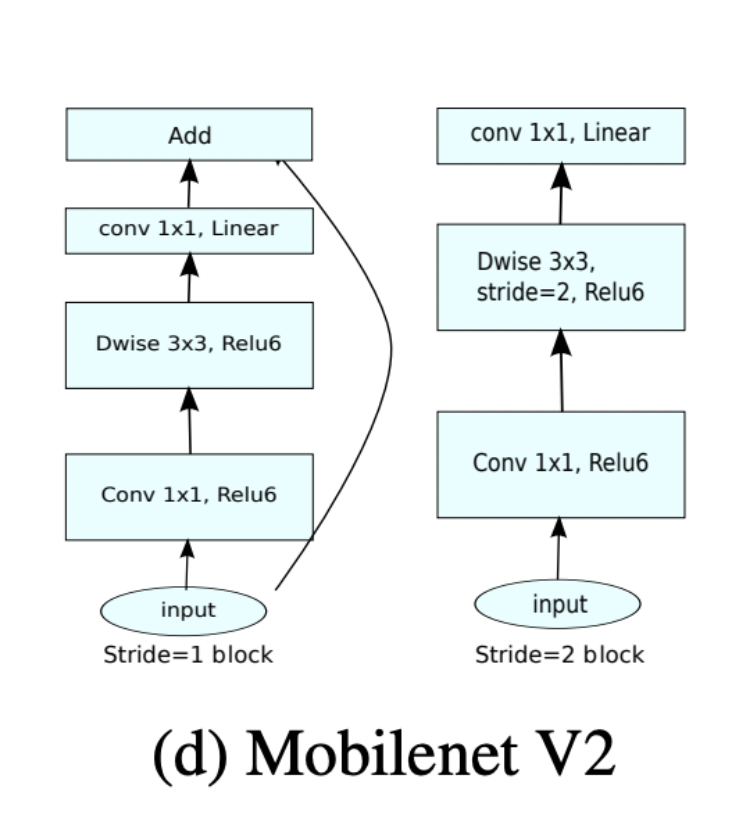

Reference: https://arxiv.org/abs/1801.04381v4

In [3]:
import torch.nn as nn
from torchsummary import summary

In [4]:
# When we set the group equal to the input. ---->       groups=ch_in
def dwise_conv(ch_in, stride=1):
    return (
        nn.Sequential(
            #depthwise
            nn.Conv2d(ch_in, ch_in, kernel_size=3, padding=1, stride=stride, groups=ch_in, bias=False),
            nn.BatchNorm2d(ch_in),
            nn.ReLU6(inplace=True),
        )
    )

In [5]:
# We define convolution functions ---->.             conv1x1 and conv3x3
def conv1x1(ch_in, ch_out):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, stride=1, bias=False),# -----> kernel = 1
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

def conv3x3(ch_in, ch_out, stride):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, stride=stride, bias=False), # kernel = 3
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

In [6]:
class InvertedBlock(nn.Module):
    def __init__(self, ch_in, ch_out, expand_ratio, stride):
        super(InvertedBlock, self).__init__()

        self.stride = stride
        assert stride in [1,2] # this function control stride must 1 or 2 else return AssertionError

        hidden_dim = ch_in * expand_ratio

        self.use_res_connect = self.stride==1 and ch_in==ch_out

        layers = []
        if expand_ratio != 1:
            layers.append(conv1x1(ch_in, hidden_dim))
        # Add the elements of  to the layers list use extend :   layers.extend(add element list) but layers.append(object) 
        # for more see this :
        # https://stackoverflow.com/questions/252703/what-is-the-difference-between-pythons-list-methods-append-and-extend
       
        layers.extend([
            #dw
            dwise_conv(hidden_dim, stride=stride),
            #pw
            conv1x1(hidden_dim, ch_out)
        ])

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.layers(x)
        else:
            return self.layers(x)


In [7]:
# stride = 1 
#(ch_in, ch_out, expand_ratio, stride)
x= InvertedBlock(3,6,2,1)
x

InvertedBlock(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=6, bias=False)
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
  )
)

In [8]:
# stride = 2
#(ch_in, ch_out, expand_ratio, stride)
x= InvertedBlock(3,6,2,2)
x

InvertedBlock(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(6, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
  )
)

In [9]:
#use_res_connect = self.stride==1 and ch_in==ch_out
#   ---->>  x + layers(x)
#(ch_in, ch_out, expand_ratio, stride)
x= InvertedBlock(3,3,2,1)
x

InvertedBlock(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=6, bias=False)
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(6, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
  )
)

[read this ](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf)

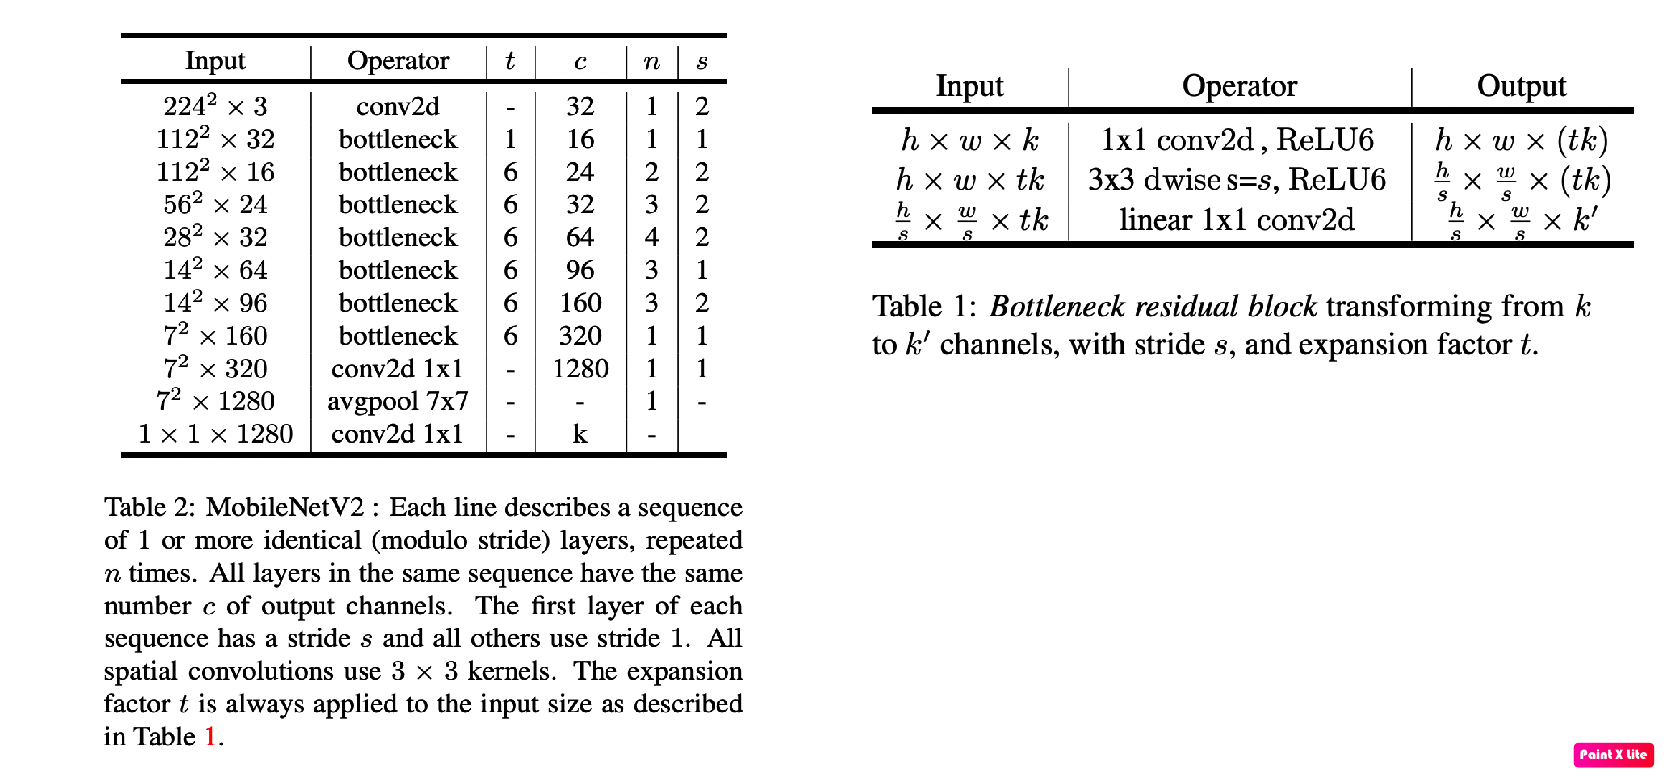

In [10]:
class MobileNetV2(nn.Module):
    def __init__(self, ch_in=3, n_classes=1000):
        super(MobileNetV2, self).__init__()

        self.configs=[
            # t, c, n, s --->  t = (expand_ratio) expansion factor in bottleneck residual block , c = output channel , n = repeates times , s = stride 
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]

        self.stem_conv = conv3x3(ch_in, 32, stride=2)

        layers = []
        input_channel = 32
        for t, c, n, s in self.configs:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedBlock(ch_in=input_channel, ch_out=c, expand_ratio=t, stride=stride))
                input_channel = c

        self.layers = nn.Sequential(*layers)

        self.last_conv = conv1x1(input_channel, 1280)

        self.classifier = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(1280, n_classes)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.layers(x)
        x = self.last_conv(x)
        x = self.avg_pool(x).view(-1, 1280)
        x = self.classifier(x)
        return x


if __name__=="__main__":
    # model check
    model = MobileNetV2(ch_in=3, n_classes=1000)
    summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
             ReLU6-9         [-1, 16, 112, 112]               0
    InvertedBlock-10         [-1, 16, 112, 112]               0
           Conv2d-11         [-1, 96, 112, 112]           1,536
      BatchNorm2d-12         [-1, 96, 112, 112]             192
            ReLU6-13         [-1, 96, 112, 112]               0
           Conv2d-14           [-1, 96,